In [1]:
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import tqdm
from torch.optim.adam import Adam

In [2]:
!cp '/content/drive/MyDrive/Colab Notebooks/Data/img_align_celeba.zip' '.'
!unzip './img_align_celeba.zip' -d "./GAN/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: ./GAN/img_align_celeba/197600.jpg  
 extracting: ./GAN/img_align_celeba/197601.jpg  
 extracting: ./GAN/img_align_celeba/197602.jpg  
 extracting: ./GAN/img_align_celeba/197603.jpg  
 extracting: ./GAN/img_align_celeba/197604.jpg  
 extracting: ./GAN/img_align_celeba/197605.jpg  
 extracting: ./GAN/img_align_celeba/197606.jpg  
 extracting: ./GAN/img_align_celeba/197607.jpg  
 extracting: ./GAN/img_align_celeba/197608.jpg  
 extracting: ./GAN/img_align_celeba/197609.jpg  
 extracting: ./GAN/img_align_celeba/197610.jpg  
 extracting: ./GAN/img_align_celeba/197611.jpg  
 extracting: ./GAN/img_align_celeba/197612.jpg  
 extracting: ./GAN/img_align_celeba/197613.jpg  
 extracting: ./GAN/img_align_celeba/197614.jpg  
 extracting: ./GAN/img_align_celeba/197615.jpg  
 extracting: ./GAN/img_align_celeba/197616.jpg  
 extracting: ./GAN/img_align_celeba/197617.jpg  
 extracting: ./GAN/img_align_celeba/197618.jpg  
 extracting: ./GAN/img_align_cele

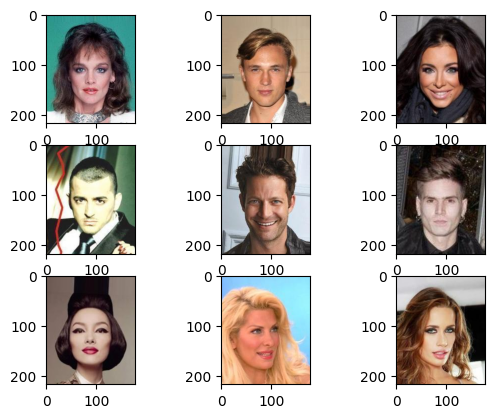

In [3]:
pth_imgs='./GAN/img_align_celeba'
imgs=glob.glob(os.path.join(pth_imgs,"*"))

for i in range(9):
  plt.subplot(3,3,i+1)
  img=Image.open(imgs[i])
  plt.imshow(img)
plt.show()

In [4]:
transforms=tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset=ImageFolder(root='./GAN', transform=transforms)
loader=DataLoader(dataset, batch_size=128, shuffle=True)


In [5]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.gen=nn.Sequential(
        nn.ConvTranspose2d(100,512,kernel_size=4,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
        #픽셀의 값을 결정하는 층이기 때문에 배치 정규화층을 사용하지 않음
        nn.Tanh(), #원점에 대해 대칭적, 어두운 색과 밝은 색을 대칭적으로 학습할 수 있도록 함
    )

  def forward(self,x):
    return self.gen(x)


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.disc=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512,1,kernel_size=4),
        nn.Sigmoid()
    )

  def forward(self,x):
    return self.disc(x)


- GAN의 합성곱층과 배치 정규화층은 특정한 방법으로 가중치를 초기화해야함
- 합성곱 : AVG=0, STD=0.02, Gaussian distribution
- Batch Norm : AVG=1.0, STD=0.02, Gaussian distribution, Bias=0
(AVG=0, STD=0.02 로 설정하는 것이 가장 학습이 잘 된다고 알려짐)



In [6]:
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G=Generator().to(device)
G.apply(weights_init)

D=Discriminator().to(device)
D.apply(weights_init)

G_optim=Adam(G.parameters(),lr=0.0001,betas=(0.5,0.999))
D_optim=Adam(D.parameters(),lr=0.0001,betas=(0.5,0.999))

for epoch in range(10):
  iterator=tqdm.tqdm(enumerate(loader,0),total=len(loader))

  for i,data in iterator:
    #data = (inputs, labels)
    D_optim.zero_grad()

    label=torch.ones_like(data[1],dtype=torch.float32).to(device)
    label_fake=torch.zeros_like(data[1],dtype=torch.float32).to(device)

    real=D(data[0].to(device))

    Dloss_real=nn.BCELoss()(torch.squeeze(real),label) #실제 이미지를 판별한 결과값,label=1
    Dloss_real.backward()

    noise=torch.randn(label.shape[0],100,1,1,device=device)
    fake=G(noise) #generator가 가짜 이미지를 생성함

    #Dloss_fake.backward()에 gradient가 반영되지 않게하기 위해서 detach() 적용
    output=D(fake.detach()) #가짜 이미지를 판별함 결과값 #detach는 eval()과 같은 형식, weight update 안됨

    Dloss_fake=nn.BCELoss()(torch.squeeze(output),label_fake)  #가짜 이미지를 판별한 결과값,label=1
    Dloss_fake.backward()

    Dloss=Dloss_real+Dloss_fake #실제 이미지와 가짜 이미지 loss의 합을 판별기에 update
    D_optim.step()

    G_optim.zero_grad()
    output=D(fake)
    Gloss=nn.BCELoss()(torch.squeeze(output),label) #판별기가 0 또는 1이라고 판단한 결과, generator 입장에서는 1이라고 판단해야 함 그러므로 label(1), 진짜 같은 가짜를 만들어야하기 때문
    Gloss.backward()

    G_optim.step()

    iterator.set_description(f'epoch:{epoch} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}')
    torch.save(G.state_dict(),'Generator.pth')
    torch.save(D.state_dict(),'Discriminator.pth')

epoch:0 iteration:1582 D_loss:0.044910915195941925 G_loss:6.718652725219727: 100%|██████████| 1583/1583 [11:21<00:00,  2.32it/s]
epoch:1 iteration:1582 D_loss:0.39711272716522217 G_loss:3.7619683742523193: 100%|██████████| 1583/1583 [11:04<00:00,  2.38it/s]
epoch:2 iteration:1582 D_loss:0.40580302476882935 G_loss:6.500768184661865: 100%|██████████| 1583/1583 [10:56<00:00,  2.41it/s]
epoch:3 iteration:1582 D_loss:0.34465569257736206 G_loss:4.067840576171875: 100%|██████████| 1583/1583 [10:54<00:00,  2.42it/s]
epoch:4 iteration:1582 D_loss:0.5225344300270081 G_loss:3.8649368286132812: 100%|██████████| 1583/1583 [10:57<00:00,  2.41it/s]
epoch:5 iteration:1582 D_loss:0.8303519487380981 G_loss:1.6068527698516846: 100%|██████████| 1583/1583 [10:56<00:00,  2.41it/s]
epoch:6 iteration:1582 D_loss:0.8274619579315186 G_loss:5.073571681976318: 100%|██████████| 1583/1583 [10:54<00:00,  2.42it/s]
epoch:7 iteration:1582 D_loss:0.3217926621437073 G_loss:2.479477882385254: 100%|██████████| 1583/1583 [

<ipython-input-10-8574ddb71ad6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('Generator.pth',map_location=device))


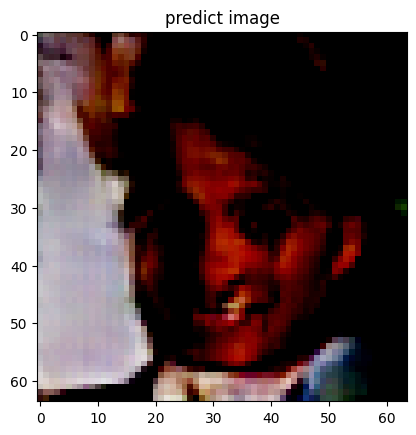

In [10]:
with torch.no_grad():
  G.load_state_dict(torch.load('Generator.pth',map_location=device))
  feature_vector=torch.randn(1,100,1,1).to(device)

  pred=G(feature_vector).squeeze()
  pred=pred.permute(1,2,0).cpu().numpy()

  plt.imshow(pred)
  plt.title('predict image')
  plt.show()